# Определение перспективного тарифа для телеком компании
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

### Шаг 1. Откройте файл с данными и изучите общую информацию.

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import numpy as np
from scipy import stats as st
import pandas as pd
from IPython.core.display import display, HTML
# На всю ширину экрана
display(HTML("<style>.container { width:100% !important; }</style>"))

Считываем данные:

In [3]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv',index_col = 'tariff_name')
users = pd.read_csv('/datasets/users.csv')

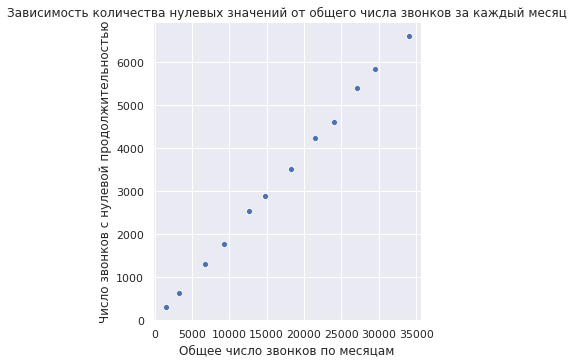

In [23]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['month'] = calls['call_date'].dt.month
calls.loc[calls['duration'] == 0, 'nulls_count'] = 1
null_calls = calls.pivot_table(index='month', values=['id', 'nulls_count'], aggfunc='count')
null_calls['null_ratio'] = round(null_calls['nulls_count'] / null_calls['id'], 2)
sns.relplot(x='id', y='nulls_count', data=null_calls)
plt.xlabel('Общее число звонков по месяцам')
plt.ylabel('Число звонков с нулевой продолжительностью')
_ = plt.title('Зависимость количества нулевых значений от общего числа звонков за каждый месяц')

In [25]:
users['unique_name'] = users['city'] + users['first_name'] + users['last_name']
users['unique_name']

0         КраснодарРафаилВерещагин
1                   МоскваИванЕжов
2      СтерлитамакЕвгенийАбрамович
3              МоскваБеллаБелякова
4       НовокузнецкТатьянаАвдеенко
                  ...             
495          ИркутскАвксентийФокин
496            ВологдаТрифонБлохин
497        ЧелябинскКаролинаАгеева
498     ВладикавказВсеволодАкимчин
499            ПермьГекторКорнилов
Name: unique_name, Length: 500, dtype: object

Изучаем:

In [3]:
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


202607 звонков, каждый имеет свой ID   
надо привести дату к правильному формату и подумать, что делать с нулевой продолжительностью некоторых звонков.

In [4]:
internet.info()
internet.head().sort_values(by = 'id')
internet['mb_used'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


0.00      19598
197.56        9
447.30        9
335.91        9
108.95        8
          ...  
72.49         1
846.22        1
429.17        1
899.03        1
483.87        1
Name: mb_used, Length: 70003, dtype: int64

149396 интернет сессий. Из них 19598 с нулевым количеством трафика.   
1 ненужный столбец `Unnamed: 0`    
дату тоже надо перевести в формат даты.

In [5]:
messages.info()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


123036 сообщений   
Дату привести в нужный формат.

In [6]:
tariffs.T

tariff_name,smart,ultra
messages_included,50,1000
mb_per_month_included,15360,30720
minutes_included,500,3000
rub_monthly_fee,550,1950
rub_per_gb,200,150
rub_per_message,3,1
rub_per_minute,3,1


Описание тарифа. Все понятно.

In [7]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [8]:
users.groupby('tariff')['user_id'].count()

tariff
smart    351
ultra    149
Name: user_id, dtype: int64

Данные пользователей, которые операторы обещают держать в секрете, вот вам и конфиденциальность.)   
Много пропусков по столбцу `churn_date` - это не проблема, пока.   
Распределение по тарифам - слабое звено выборки: СМАРТ гораздо больше чем УЛЬТРА.
76 городов. Максимальное количество абонентов в Москве - 99 (25% выборки)   
Тоже дату перевести в нормальный формат, да и все.

# Шаг 2. Подготовьте данные
### Исправляем ошибки в данных

Исправим формат колонок с датами для всех таблиц:

In [9]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

Продолжительность звонков 0.00 для расчета сумм потраченных/заработанных не представляет интереса.   
Сколько их:

In [10]:
calls.query('duration == 0')['id'].count()

39613

Возможно это недозвоны, иликакие-то ошибки при сборе данных. Если бы это были какие-то незначительные, в несколько секунт вызовы, их следовало бы округлить вверх до целой минуты. Нули не были засчитаны оператором как минуты разговора включенные в тариф или сверх предоплаченных. Значит эти строки не будут представлять ценности при расчете прибыли компании с каждого клиента.   Исключим все эти строки сделав срез. 

In [11]:
calls = calls.query('duration > 0')
calls.shape

(162994, 4)

Так же поступим с нулевыми интернет сессиями.

In [12]:
internet = internet.query('mb_used > 0')
internet.shape

(129798, 5)

Так же в процессе подготовки данных нужно их округлить до целых значений в большую сторону, согласно условиям тарификации.

In [13]:
calls['duration'] = np.ceil(calls['duration'])
internet['mb_used'] = np.ceil(internet['mb_used'])

### Посчитайте для каждого пользователя:
количество сделанных звонков и израсходованных минут разговора по месяцам;   
количество отправленных сообщений по месяцам;   
объем израсходованного интернет-трафика по месяцам;   
помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Создаем столбец month для подсчета количества звонков, смс и трафика помесячно.


In [14]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

Рассчитываем длительность звонков по месяцам для каждого абонента:   
количество отправленных сообщений по месяцам;   
объем израсходованного интернет-трафика по месяцам

In [15]:
calls_user_month = calls.groupby(['user_id','month']).\
        agg({'duration' : 'sum'}, as_index = False).astype(int)
internet_user_month = internet.groupby(['user_id','month']).\
        agg({'mb_used' : 'sum'}, as_index = False).astype(int)
messages_user_month = messages.pivot_table(index = ['user_id', 'month'],\
        values = 'id', aggfunc='count').reset_index().astype(int)
#Переименование колонок для messages_user_month
messages_user_month.columns = ['user_id', 'month', 'messages']

Соединяем полученные таблицы в один датафрейм:

In [16]:
df = calls_user_month.merge(internet_user_month, how = 'outer', on = ['user_id', 'month'])\
.merge(messages_user_month, how = 'outer', on = ['user_id', 'month'])\
.merge(users[['user_id', 'tariff', 'city']], how = 'left', on = 'user_id')
df

,user_id,month,duration,mb_used,messages,tariff,city
0,1000,5,159.0,2256.0,22.0,ultra,Краснодар
1,1000,6,172.0,23257.0,60.0,ultra,Краснодар
2,1000,7,340.0,14016.0,75.0,ultra,Краснодар
3,1000,8,408.0,14070.0,81.0,ultra,Краснодар
4,1000,9,466.0,14581.0,57.0,ultra,Краснодар
...,...,...,...,...,...,...,...
3209,1489,8,NaN,11066.0,17.0,smart,Санкт-Петербург
3210,1489,9,NaN,17232.0,32.0,smart,Санкт-Петербург
3211,1489,10,NaN,19588.0,21.0,smart,Санкт-Петербург
3212,1489,11,NaN,17516.0,20.0,smart,Санкт-Петербург


Итого имеем 3214 строк среднемесячных показателей

Не понимаю почему, но целочисленные значения в раздельных таблицах стали float после объединения.   
При заполнении пропусков прописываю заново тип данных.    
Пропуски появились в строках, когда конкретный абонент в течение месяца, например, разговаривал по телефону, но не отправил ни одного смс. То есть использовал не все из имеющихся 3-х благ сотовой связи.

In [17]:
def fillna_and_convert_to_int(df, columns):
    for col in columns:
        df[col] = df[col].fillna(0).astype(int)
    return df

In [18]:
fillna_and_convert_to_int(df, ['messages', 'duration', 'mb_used'])

,user_id,month,duration,mb_used,messages,tariff,city
0,1000,5,159,2256,22,ultra,Краснодар
1,1000,6,172,23257,60,ultra,Краснодар
2,1000,7,340,14016,75,ultra,Краснодар
3,1000,8,408,14070,81,ultra,Краснодар
4,1000,9,466,14581,57,ultra,Краснодар
...,...,...,...,...,...,...,...
3209,1489,8,0,11066,17,smart,Санкт-Петербург
3210,1489,9,0,17232,32,smart,Санкт-Петербург
3211,1489,10,0,19588,21,smart,Санкт-Петербург
3212,1489,11,0,17516,20,smart,Санкт-Петербург


Создаем функцию для расчета израсходованных минут, Мб, смс сверх тарифа и профита с каждого пользователя:

In [19]:
tariffs = pd.read_csv('/datasets/tariffs.csv', index_col = 'tariff_name')
def get_profit_above (row, tariffs = tariffs):
    tariff = row['tariff']
    calls_above = max(row['duration'] - tariffs.loc[tariff, 'minutes_included'], 0)
    sms_above = max(row['messages'] - tariffs.loc[tariff, 'messages_included'], 0)
    internet_above = max(np.ceil((row['mb_used'] - tariffs.loc[tariff, 'mb_per_month_included'])/1024), 0)
    profit = calls_above * tariffs.loc[tariff, 'rub_per_minute'] + tariffs.loc[tariff, 'rub_monthly_fee']\
    + sms_above * tariffs.loc[tariff, 'rub_per_message']\
    + internet_above * tariffs.loc[tariff, 'rub_per_gb']
    
    return calls_above, sms_above, internet_above, profit

Вызываем функцию для расчета профита:

In [20]:
df[['calls_after_limit', 'ms_after_limit', 'gb_after_limit', 'profit']] = \
df[['tariff', 'duration', 'mb_used', 'messages']].\
apply(get_profit_above, axis = 1, result_type = "expand")
df

,user_id,month,duration,mb_used,messages,tariff,city,calls_after_limit,ms_after_limit,gb_after_limit,profit
0,1000,5,159,2256,22,ultra,Краснодар,0.0,0.0,0.0,1950.0
1,1000,6,172,23257,60,ultra,Краснодар,0.0,0.0,0.0,1950.0
2,1000,7,340,14016,75,ultra,Краснодар,0.0,0.0,0.0,1950.0
3,1000,8,408,14070,81,ultra,Краснодар,0.0,0.0,0.0,1950.0
4,1000,9,466,14581,57,ultra,Краснодар,0.0,0.0,0.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,0,11066,17,smart,Санкт-Петербург,0.0,0.0,0.0,550.0
3210,1489,9,0,17232,32,smart,Санкт-Петербург,0.0,0.0,2.0,950.0
3211,1489,10,0,19588,21,smart,Санкт-Петербург,0.0,0.0,5.0,1550.0
3212,1489,11,0,17516,20,smart,Санкт-Петербург,0.0,0.0,3.0,1150.0


Получили 3214 строк со среднемесячными показателями

In [21]:
print('Количество наблюдений по тарифу УЛЬТРА:', len(df.query('tariff == "ultra"')['user_id']))
print('Количество наблюдений по тарифу СМАРТ:', len(df.query('tariff == "smart"')['user_id']))

Количество наблюдений по тарифу УЛЬТРА: 985
Количество наблюдений по тарифу СМАРТ: 2229


Распределение по тарифам не равномерное, со значительным перевесом абонентов более дешевого СМАРТа.

# Шаг 3. Проанализируйте данные
Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

Если разбивать по тарифам то можно подсчитать среднее количество минут, сообщений и тафика по каждому:

In [22]:
mean_tariff = df.pivot_table(index=['tariff'], values = ['duration', 'mb_used', 'messages']).astype(int)
mean_tariff

,duration,mb_used,messages
tariff,,,
smart,417,16229,33
ultra,526,19486,49


По каждому показателю УЛЬТРА лидирует

Рассчитаем дисперсию для этих данных. Поскольку наши 500 абонентов - выборка, будем использовать функцию для расчета дисперсии на выборке:

In [23]:
variance_smart = np.var(df.query('tariff == "smart"')[['duration', 'mb_used', 'messages']], ddof=1)
print('Дисперсия для количества израсходованных минут, сообщений и трафика пользователей тарифа СМАРТ')
print()
print(variance_smart.astype(int))

Дисперсия для количества израсходованных минут, сообщений и трафика пользователей тарифа СМАРТ

duration       36219
mb_used     34545911
messages         796
dtype: int64


In [24]:
variance_ultra = np.var(df.query('tariff == "ultra"')[['duration', 'mb_used', 'messages']], ddof=1)
print('Дисперсия для количества израсходованных минут, сообщений и трафика пользователей тарифа УЛЬТРА')
print()
print(variance_ultra.astype(int))

Дисперсия для количества израсходованных минут, сообщений и трафика пользователей тарифа УЛЬТРА

duration       100873
mb_used     101935621
messages         2285
dtype: int64


Расчитаем стандартное отклонение так же отдельно по каждому тарифу:
Поскольку дисперсия нам известна, извлечем из нее квадратный корень.

In [25]:
std_dev_smart = np.sqrt(variance_smart)
std_dev_ultra = np.sqrt(variance_ultra)
print('Стандартное отклонение по тарифу СМАРТ:')
print(std_dev_smart)
print()
print('Стандартное отклонение по тарифу УЛЬТРА:')
print(std_dev_ultra)

Стандартное отклонение по тарифу СМАРТ:
duration     190.313730
mb_used     5877.576978
messages      28.227876
dtype: float64

Стандартное отклонение по тарифу УЛЬТРА:
duration      317.606098
mb_used     10096.317202
messages       47.804457
dtype: float64


Строим гистограммы:   
Сначала для всего датафрейма

Распределение среднемесячных показателей


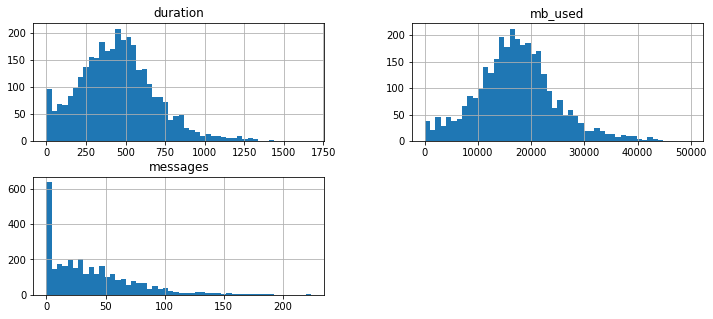

In [26]:
df[['duration', 'mb_used', 'messages']].hist(bins=50, figsize = (12, 5))
print('Распределение среднемесячных показателей')

По интернет-трафику видим нормальное распределение, а СМСками многие вообще не пользуются.

Теперь разделим по тарифам:   
Будем смотреть в сравнении каждый параметр сразу по двум тарифам.

Звонки


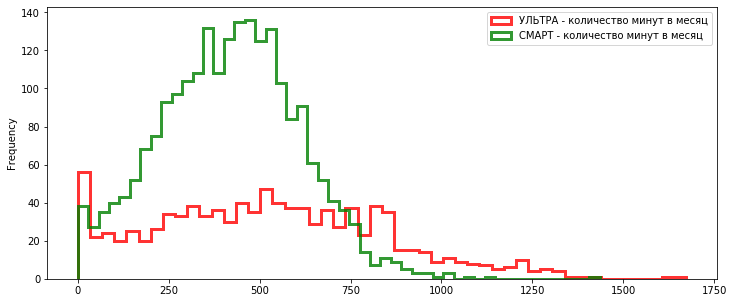

In [27]:
ax = df.query('tariff == "ultra"')['duration'].\
plot(kind='hist', y='column', histtype='step', bins=50, linewidth=3,\
     figsize = (12,5), color = 'r', label='УЛЬТРА - количество минут в месяц',\
     legend=True, alpha=0.8)
df.query('tariff == "smart"')['duration'].\
plot(kind='hist', y='column', histtype='step', bins=50, linewidth=3,\
     figsize = (12,5), color = 'g', label='СМАРТ - количество минут в месяц',\
     legend=True, ax = ax, alpha=0.8)
print('Звонки')

На гистограмме явно отразилась разница в количестве данных по тарифам.   
Абоненты СМАРТа превышают свой лимит в 500 минут довольно часто.   
Абоненты УЛЬТРА в подавляющем большинстве не договаривают и до середины предоплаченного времени.

Сообщения


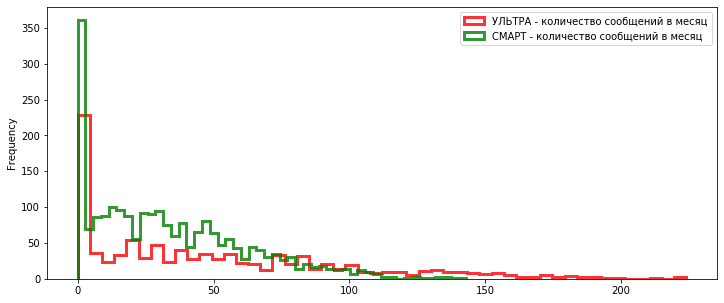

In [28]:
ax = df.query('tariff == "ultra"')['messages'].\
plot(kind='hist', y='column', histtype='step', bins=50, linewidth=3,\
     figsize = (12,5), color = 'r', label='УЛЬТРА - количество сообщений в месяц',\
     legend=True, alpha=0.8)
df.query('tariff == "smart"')['messages'].\
plot(kind='hist', y='column', histtype='step', bins=50, linewidth=3,\
     figsize = (12,5), color = 'g', label='СМАРТ - количество сообщений в месяц',\
     legend=True, ax = ax, alpha=0.8)
print('Сообщения')

50-ти сообщений (СМАРТ) явно недостаточно на месяц, а 1000 (УЛЬТРА) не нужна никому.

Интернет


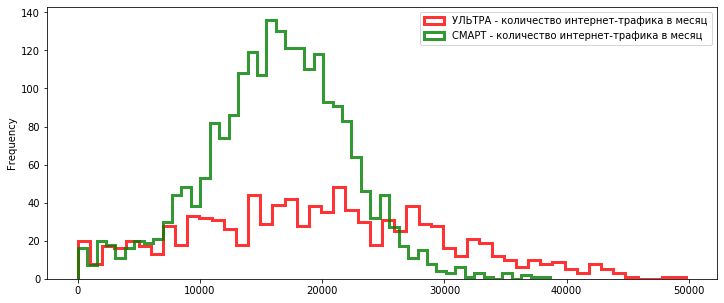

In [29]:
ax = df.query('tariff == "ultra"')['mb_used'].\
plot(kind='hist', y='column', histtype='step', bins=50, linewidth=3,\
     figsize = (12,5), color = 'r', label='УЛЬТРА - количество интернет-трафика в месяц',\
     legend=True, alpha=0.8)
df.query('tariff == "smart"')['mb_used'].\
plot(kind='hist', y='column', histtype='step', bins=50, linewidth=3,\
     figsize = (12,5), color = 'g', label='СМАРТ - количество интернет-трафика в месяц',\
     legend=True, ax = ax, alpha=0.8)
print('Интернет')

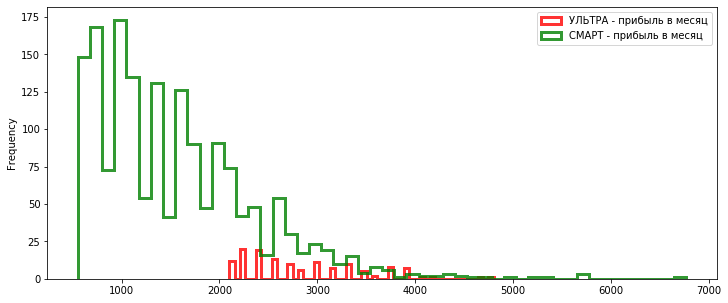

In [30]:
ax = df.query('tariff == "ultra" and profit > 1950')['profit'].\
plot(kind='hist', y='column', histtype='step', bins=50, linewidth=3,\
     figsize = (12,5), color = 'r', label='УЛЬТРА - прибыль в месяц',\
     legend=True, alpha=0.8)
df.query('tariff == "smart" and profit > 550')['profit'].\
plot(kind='hist', y='column', histtype='step', bins=50, linewidth=3,\
     figsize = (12,5), color = 'g', label='СМАРТ - прибыль в месяц',\
     legend=True, ax = ax, alpha=0.8)

Из-за значительного перевеса Смартав выборке оценить прибыльность по гистограмме невозможно.

In [31]:
print('За 2018 год абоненты тарифа СМАРТ принесли нам:', df.query('tariff == "smart"')['profit'].sum())
print('За 2018 год абоненты тарифа УЛЬТРА принесли нам:', df.query('tariff == "ultra"')['profit'].sum())

За 2018 год абоненты тарифа СМАРТ принесли нам: 2885751.0
За 2018 год абоненты тарифа УЛЬТРА принесли нам: 2040000.0


# Шаг 4. Проверьте гипотезы

### 1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

In [32]:
# Здесь просто ради интереса посчитаем средние значения по столбцам, 
# понятно что к статистическим методам это не имеет отношения.
print('Средняя выручка абонентов тарифа УЛЬТРА: {:.2f}'.\
      format(df.query('tariff == "ultra"')['profit'].mean()))
print('Средняя выручка абонентов тарифа СМАРТ: {:.2f}'.\
      format(df.query('tariff == "smart"')['profit'].mean()))

Средняя выручка абонентов тарифа УЛЬТРА: 2071.07
Средняя выручка абонентов тарифа СМАРТ: 1294.64


Нулевая гипотеза (H₀) всегда формулируется со знаком равно, значит в данном случае она будет звучать так: "Средняя выручка пользователей тариф «Ультра» равна средней выручке пользователей тарифа «Смарт»".  
Тогда альтернативная гипотеза (H₁) - "средние выручки не равны."\
Метод для проверки выбираю, как мне кажется, наиболее подходящий из описанных в спринте - Гипотеза о равенстве средних двух генеральных совокупностей. Генеральными совокупностями будем считать всех абонентов определенного тарифа.\
Берем выборки профита по тарифам, сохраняем как переменные для сравнения,
alpha - как в учебнике - наиболее часто используемое в статистике значение.\
Исходя из разницы в дисперсий выборок предположим, что дисперсии генеральных совокупностей тоже разные - добавим параметр equal_var = False.

In [33]:
ultra = df.query('tariff == "ultra"')['profit']
smart = df.query('tariff == "smart"')['profit']
alpha = 0.05
results = st.ttest_ind(ultra, smart, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.7240946993530846e-246
Отвергаем нулевую гипотезу


Исходя из проведенного расчета:   
Нулевую гипотезу отвергаем - значит средние выручки от тарифов различаются.

### 2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Формулируем нулевую гипотезу:\
Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.\
Альтернативная: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
Сделаем 2 среза с выручкой пользователей и применим тот же метод, что и выше.

Предварительно расчитаем дисперсию по этим срезам:

In [34]:
variance_moscow = np.var(df.query('city == "Москва"')['profit'], ddof=1)
variance_regions = np.var(df.query('city != "Москва"')['profit'], ddof=1)

print('Дисперсия средней выручки пользователей из Москвы равна', variance_moscow)
print('Дисперсия средней выручки пользователей из других регионов равна', variance_regions)

Дисперсия средней выручки пользователей из Москвы равна 566183.0292184273
Дисперсия средней выручки пользователей из других регионов равна 656766.5955122437


Мне сложно судить можно ли считать значимым различие в дисперсии в районе 20%.\
Предположу что это не много, тогда equal_var = True

In [35]:
moscow = df.query('city == "Москва"')['profit']
regions = df.query('city != "Москва"')['profit']
alpha = 0.05
results = st.ttest_ind(moscow, regions, equal_var = True)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.531666503831252
Не получилось отвергнуть нулевую гипотезу


Нулевую гипотезу не отвергаем. Получается, что, хотя средние выручки и не одинаковы, в 53% случаев данные различия можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними выручками.

Вывод: Возможно и правда выручка московских абонентов не отличается от выручки из других регионов.

# Шаг 5. Общий вывод

Данные были изучены. Проблемы в них исправлены.   
Для каждого абонента рассчитано количество потребляемых им услуг помесячно.   
Рассчитал выручку с каждого абонента за каждый месяц его пользования сетью.   
Поскольку у нас получились очень разные по количеству группы абонентов с разными тарифами, мне кажется судить о том, насколько кто-то из них приносит больше прибыли тяжело.   
Наверно для этого и существуют статистические методы: расчет при проверке гипотез о равенстве средней выручки показал, что средняя выручка от абонентов разных тарифов отличается, а от региона нахождения абонента скорее всего не зависит.   
В нашей выборке оказалось 70% абонентов СМАРТ и 30% УЛЬТРА.   
Выручки за 2018г они сделали 58% и 42% соответственно.